Download Dataset

In [1]:
# !mkdir test train
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"codefarmer8408","key":"5c7d212a5ec645c0962100d3fef57e42"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andyczhao/covidx-cxr2

The syntax of the command is incorrect.
The system cannot find the path specified.
chmod: cannot access '~/.kaggle/kaggle.json': No such file or directory


covidx-cxr2.zip: Skipping, found more recently modified local copy (use --force to force download)


unzip downloaded data

In [2]:
!unzip covidx-cxr2.zip

^C


Archive:  covidx-cxr2.zip


  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of covidx-cxr2.zip or
        covidx-cxr2.zip.zip, and cannot find covidx-cxr2.zip.ZIP, period.


Create Dataset Parser

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import time
import datetime

class COVIDDataset(Dataset):
    def __init__(self, data_file, transform=None):
        self.data = []
        self.transform = transform
        self.map = {'negative': 0, 'positive': 1}
        
        with open(data_file, 'r') as f:
            folder = os.path.splitext(data_file)[0]
            for line in f:
                patient_id, filename, label, data_source = line.strip().split(' ')
                image_path = os.path.join(folder, filename)
                self.data.append((image_path ,self.map[label]))
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [14]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed, 2))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Create CNN Model

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt

from tqdm import tqdm

# Things to try: search "TUNABLE"

class PEPX(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super(PEPX, self).__init__()
        hidden_channels = int(out_channels / expansion_factor)

        self.projection = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        self.expansion = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        self.depthwise = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, groups=out_channels)
        self.second_projection = nn.Conv2d(out_channels, hidden_channels, kernel_size=1)
        self.extension = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.projection(x)
        # identity = x
        x = self.expansion(x)
        x = nn.functional.relu(x, inplace=True)
        x = self.depthwise(x)
        x = nn.functional.relu(x, inplace=True)
        x = self.second_projection(x)
        x = self.extension(x)
        # x += identity
        x = nn.functional.relu(x, inplace=True)
        return x
    
class PEPX_Downsample(PEPX):
    """Same as pepx but makes the input smaller by half"""
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super(PEPX_Downsample, self).__init__(in_channels, out_channels, expansion_factor)
        self.downsample = nn.MaxPool2d(kernel_size=4, stride=4)
        
    def forward(self, x):
        x = self.projection(x)
        # identity = x
        x = self.expansion(x)
        x = nn.functional.relu(x, inplace=True)
        x = self.depthwise(x)
        x = nn.functional.relu(x, inplace=True)
        x = self.second_projection(x)
        x = self.extension(x)
        # x += identity
        x = nn.functional.relu(x, inplace=True)
        x = self.downsample(x)
        return x


class COVIDNet(nn.Module):
    def __init__(self, num_classes=2):
        super(COVIDNet, self).__init__()
        # first conv layer
        self.conv7x7 = nn.Conv2d(3, 56, kernel_size=7, stride=2, padding=3)
        # top conv layers
        self.conv1 = nn.Conv2d(56, 56, kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(56 * 4, 112, kernel_size=4, stride=4)
        # self.conv3 = nn.Conv2d(112 * 5, 224, kernel_size=2, stride=2)
        # self.conv4 = nn.Conv2d(216 * 5 + 224 * 2, 424, kernel_size=2, stride=2)

        # pepx layers
        self.pepx11 = PEPX_Downsample(56, 56)
        self.pepx12 = PEPX(56 * 2, 56)
        self.pepx13 = PEPX(56 * 3, 56)

        self.pepx21 = PEPX_Downsample(56 * 4, 112)
        self.pepx22 = PEPX(112 * 2, 112)
        self.pepx23 = PEPX(112 * 3, 112)
        self.pepx24 = PEPX(112 * 4, 112)

        # self.pepx31 = PEPX_Downsample(112 * 5, 216)
        # self.pepx32 = PEPX(216 + 224, 216)
        # self.pepx33 = PEPX(216 * 2 + 224, 216)
        # self.pepx34 = PEPX(216 * 3 + 224, 216)
        # self.pepx35 = PEPX(216 * 4 + 224, 216)
        # self.pepx36 = PEPX(216 * 5 + 224, 224)

        # self.pepx41 = PEPX_Downsample(216 * 5 + 224 * 2, 424)
        # self.pepx42 = PEPX(424 * 2, 424)
        # self.pepx43 = PEPX(424 * 3, 400)

        # final layers
        self.flatten = nn.Flatten()
        # 370800? 15x15x(400+424+424+424)
        # NOT 460800? 15x15x(400+400+400+424+424)
        self.fc = nn.Linear(126000, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Conv7x7 layer
        x = self.conv7x7(x)
        x = nn.ReLU(inplace=True)(x)
        
        # print(pepx11")
        # PEPX11 module
        pepx11 = self.pepx11(x)
        conv1 = self.conv1(x)

        # print(f"size of pepx11 = {pepx11.size()}, size of conv1 = {conv1.size()}")
        # print(pepx12")        
        # PEPX12 module
        pepx12 = self.pepx12(torch.cat((pepx11, conv1), dim=1))
        # print(f"size of pepx12 = {pepx12.size()}")

        # print(pepx13")
        # PEPX13 module
        pepx13 = self.pepx13(torch.cat((pepx12, pepx11, conv1), dim=1))
        # print(f"size of pepx13 = {pepx13.size()}")

        # print(pepx21")
        # PEPX21 module
        cat = torch.cat((pepx13, pepx12, pepx11, conv1), dim=1)
        pepx21 = self.pepx21(cat)
        conv2 = self.conv2(cat)
        # print(f"size of pepx21 = {pepx21.size()}, size of conv2 = {conv2.size()}")

        # print(pepx22")
        # PEPX22 module
        pepx22 = self.pepx22(torch.cat((pepx21, conv2), dim=1))
        # print(f"size of pepx22 = {pepx22.size()}")

        # print(pepx23")
        # PEPX23 module
        pepx23 = self.pepx23(torch.cat((pepx22, pepx21, conv2), dim=1))
        # print(f"size of pepx23 = {pepx23.size()}")

        # print(pepx24")
        # PEPX24 module
        pepx24 = self.pepx24(torch.cat((pepx23, pepx22, pepx21, conv2), dim=1))
        # print(f"size of pepx24 = {pepx24.size()}")

        # # print(pepx31")
        # # PEPX31 module
        # cat = torch.cat((pepx24, pepx23, pepx22, pepx21, conv2), dim=1)
        # pepx31 = self.pepx31(cat)
        # conv3 = self.conv3(cat)
        # # print(f"size of pepx31 = {pepx31.size()}, size of conv3 = {conv3.size()}")

        # # print(pepx32")
        # # PEPX32 module
        # pepx32 = self.pepx32(torch.cat((pepx31, conv3), dim=1))
        # # print(f"size of pepx32 = {pepx32.size()}")

        # # print(pepx33")
        # # PEPX33 module
        # pepx33 = self.pepx33(torch.cat((pepx32, pepx31, conv3), dim=1))
        # # print(f"size of pepx33 = {pepx33.size()}")

        # # print(pepx34")
        # # PEPX34 module
        # pepx34 = self.pepx34(torch.cat((pepx33, pepx32, pepx31, conv3), dim=1))
        # # print(f"size of pepx34 = {pepx34.size()}")

        # # print(pepx35")
        # # PEPX35 module
        # pepx35 = self.pepx35(torch.cat((pepx34, pepx33, pepx32, pepx31, conv3), dim=1))
        # # print(f"size of pepx35 = {pepx35.size()}")

        # # print(pepx36")
        # # PEPX36 module
        # pepx36 = self.pepx36(torch.cat((pepx35, pepx34, pepx33, pepx32, pepx31, conv3), dim=1))
        # # print(f"size of pepx36 = {pepx36.size()}")

        # # print(pepx41")
        # # PEPX41 module
        # cat = torch.cat((pepx36, pepx35, pepx34, pepx33, pepx32, pepx31, conv3), dim=1)
        # pepx41 = self.pepx41(cat)
        # conv4 = self.conv4(cat)
        # # print(f"size of pepx41 = {pepx41.size()}, size of conv4 = {conv4.size()}")

        # # print(pepx42")
        # # PEPX42 module
        # pepx42 = self.pepx42(torch.cat((pepx41, conv4), dim=1))
        # # print(f"size of pepx42 = {pepx42.size()}")

        # # print(pepx43")
        # # PEPX43 module
        # pepx43 = self.pepx43(torch.cat((pepx42, pepx41, conv4), dim=1))
        # # print(f"size of pepx43 = {pepx43.size()}")
    
        # Flatten and FC layer
        x = self.flatten(torch.cat([pepx24, pepx23, pepx22, pepx21, conv2], dim=1))
        # print(f"size of flatten = {x.size()}")
        x = self.fc(x)
        # print(f"size of fc = {x.size()}")
        
        # Softmax activation
        x = self.softmax(x)
        # print(f"size of softmax = {x.size()}")
        
        return x


def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    print(f'Loading # {len(train_loader)} datas')
    t0 = time.time()
    with tqdm(train_loader, unit='batch') as tepoch:
        for data, target in tepoch:
            tepoch.set_description(f"Training")

            data, target = data.to(device), target.to(device)

            # instead of  optimizer.zero_grad(), do it in forloop for more efficiency
            for param in model.parameters():
                param.grad = None

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
    acc = 100.*correct/total
    return train_loss, acc

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    t0 = time.time()
    with torch.no_grad():
        with tqdm(val_loader, unit="batch") as tepoch:
            for data, target in tepoch:
                tepoch.set_description(f"Validating")
                
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
            
    print("  * Validation took: {:}".format(format_time(time.time() - t0)))
    acc = 100.*correct/total
    return val_loss, acc

Train

In [16]:
# Set up hyperparameters and data loaders
# TUNABLE:
# lr = 2e-4
lr = 5e-5

# TUNABLE:
epochs = 25
# TUNABLE: original 64
batch_size = 48
# TUNABLE:
factor = 0.7
# TUNABLE:
patience = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# transform = transforms.Compose([
#     transforms.Resize((480, 480)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Define the transformations to be applied to the data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# create COVIDDataset object
# TUNABLE: --> can try different datasets
dataset = COVIDDataset('train.txt', transform=transform)

# get size of dataset
dataset_size = len(dataset)

# split dataset into train and validation sets
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])


# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Set up model, optimizer, and loss function
model = COVIDNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# TUNABLE:
criterion = F.cross_entropy
#criterion = F.mse_loss

# Train the model
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=True)
best_acc = 0

# record training and validation losses and accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []
start = time.time()
print(f"Began training for {epochs} epochs")
for epoch in range(1, epochs + 1):
    print(f'Training (Epoch {epoch})')
    torch.cuda.empty_cache()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)    
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # record training and validation losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step(val_loss)
    
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'new_covid_net.pt')

print("Training complete in {}".format(format_time(time.time() - start)))
print(f'Best validation accuracy: {best_acc:.2f}%')

Using device: cuda
Began training for 25 epochs
Training (Epoch 1)
Loading # 500 datas


Training: 100%|██████████| 500/500 [08:15<00:00,  1.01batch/s]


  * Training epoch took: 0:08:15


Validating: 100%|██████████| 125/125 [01:43<00:00,  1.21batch/s]


  * Validation took: 0:01:43
Epoch 1, Train Loss: 258.6700, Train Acc: 78.50, Val Loss: 61.8104, Val Acc: 80.94
Training (Epoch 2)
Loading # 500 datas


Training: 100%|██████████| 500/500 [08:12<00:00,  1.02batch/s]


  * Training epoch took: 0:08:12


Validating: 100%|██████████| 125/125 [01:43<00:00,  1.21batch/s]


  * Validation took: 0:01:43
Epoch 2, Train Loss: 239.1950, Train Acc: 82.65, Val Loss: 57.3798, Val Acc: 84.88
Training (Epoch 3)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:47<00:00,  1.07batch/s]


  * Training epoch took: 0:07:47


Validating: 100%|██████████| 125/125 [01:37<00:00,  1.28batch/s]


  * Validation took: 0:01:37
Epoch 3, Train Loss: 220.0853, Train Acc: 86.84, Val Loss: 53.6891, Val Acc: 88.10
Training (Epoch 4)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:32<00:00,  1.10batch/s]


  * Training epoch took: 0:07:32


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]


  * Validation took: 0:01:39
Epoch 4, Train Loss: 203.9262, Train Acc: 90.35, Val Loss: 51.0947, Val Acc: 90.16
Training (Epoch 5)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:34<00:00,  1.10batch/s]


  * Training epoch took: 0:07:34


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]


  * Validation took: 0:01:39
Epoch 5, Train Loss: 193.7618, Train Acc: 92.42, Val Loss: 48.0861, Val Acc: 92.80
Training (Epoch 6)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:35<00:00,  1.10batch/s]


  * Training epoch took: 0:07:35


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]


  * Validation took: 0:01:39
Epoch 6, Train Loss: 185.2572, Train Acc: 94.13, Val Loss: 46.5080, Val Acc: 93.98
Training (Epoch 7)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:31<00:00,  1.11batch/s]


  * Training epoch took: 0:07:31


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.27batch/s]


  * Validation took: 0:01:38
Epoch 7, Train Loss: 180.8290, Train Acc: 95.20, Val Loss: 45.2780, Val Acc: 95.18
Training (Epoch 8)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:29<00:00,  1.11batch/s]


  * Training epoch took: 0:07:29


Validating: 100%|██████████| 125/125 [01:37<00:00,  1.28batch/s]


  * Validation took: 0:01:37
Epoch 8, Train Loss: 178.4858, Train Acc: 95.59, Val Loss: 45.3202, Val Acc: 94.98
Training (Epoch 9)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:29<00:00,  1.11batch/s]


  * Training epoch took: 0:07:29


Validating: 100%|██████████| 125/125 [01:37<00:00,  1.28batch/s]


  * Validation took: 0:01:37
Epoch 9, Train Loss: 177.4790, Train Acc: 95.79, Val Loss: 45.8248, Val Acc: 94.63
Training (Epoch 10)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:29<00:00,  1.11batch/s]


  * Training epoch took: 0:07:29


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.27batch/s]


  * Validation took: 0:01:38
Epoch 10, Train Loss: 176.2233, Train Acc: 96.09, Val Loss: 44.5185, Val Acc: 95.52
Training (Epoch 11)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:32<00:00,  1.10batch/s]


  * Training epoch took: 0:07:32


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]


  * Validation took: 0:01:39
Epoch 11, Train Loss: 175.1099, Train Acc: 96.24, Val Loss: 44.5257, Val Acc: 95.42
Training (Epoch 12)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:35<00:00,  1.10batch/s]


  * Training epoch took: 0:07:35


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.26batch/s]


  * Validation took: 0:01:38
Epoch 12, Train Loss: 174.1654, Train Acc: 96.42, Val Loss: 44.5014, Val Acc: 95.60
Training (Epoch 13)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:34<00:00,  1.10batch/s]


  * Training epoch took: 0:07:34


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.27batch/s]


  * Validation took: 0:01:38
Epoch 13, Train Loss: 173.2368, Train Acc: 96.64, Val Loss: 44.0840, Val Acc: 95.98
Training (Epoch 14)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:32<00:00,  1.11batch/s]


  * Training epoch took: 0:07:32


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.27batch/s]


  * Validation took: 0:01:38
Epoch 14, Train Loss: 172.8403, Train Acc: 96.73, Val Loss: 44.2562, Val Acc: 95.83
Training (Epoch 15)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:29<00:00,  1.11batch/s]


  * Training epoch took: 0:07:29


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.27batch/s]


  * Validation took: 0:01:38
Epoch 15, Train Loss: 172.8161, Train Acc: 96.76, Val Loss: 44.4835, Val Acc: 95.63
Training (Epoch 16)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:29<00:00,  1.11batch/s]


  * Training epoch took: 0:07:29


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.28batch/s]


  * Validation took: 0:01:38
Epoch 16, Train Loss: 171.9794, Train Acc: 96.94, Val Loss: 44.1938, Val Acc: 95.93
Training (Epoch 17)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:30<00:00,  1.11batch/s]


  * Training epoch took: 0:07:30


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]


  * Validation took: 0:01:39
Epoch 17, Train Loss: 171.1905, Train Acc: 97.07, Val Loss: 44.2203, Val Acc: 95.90
Training (Epoch 18)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:33<00:00,  1.10batch/s]


  * Training epoch took: 0:07:33


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]


  * Validation took: 0:01:39
Epoch 18, Train Loss: 170.5391, Train Acc: 97.18, Val Loss: 44.1302, Val Acc: 95.85
Training (Epoch 19)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:36<00:00,  1.10batch/s]


  * Training epoch took: 0:07:36


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]


  * Validation took: 0:01:39
Epoch 00019: reducing learning rate of group 0 to 3.5000e-05.
Epoch 19, Train Loss: 170.6490, Train Acc: 97.18, Val Loss: 45.2735, Val Acc: 94.90
Training (Epoch 20)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:33<00:00,  1.10batch/s]


  * Training epoch took: 0:07:33


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]


  * Validation took: 0:01:39
Epoch 20, Train Loss: 169.1167, Train Acc: 97.51, Val Loss: 43.6994, Val Acc: 96.25
Training (Epoch 21)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:33<00:00,  1.10batch/s]


  * Training epoch took: 0:07:33


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.27batch/s]


  * Validation took: 0:01:38
Epoch 21, Train Loss: 168.3403, Train Acc: 97.65, Val Loss: 43.5780, Val Acc: 96.35
Training (Epoch 22)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:30<00:00,  1.11batch/s]


  * Training epoch took: 0:07:30


Validating: 100%|██████████| 125/125 [01:37<00:00,  1.28batch/s]


  * Validation took: 0:01:37
Epoch 22, Train Loss: 167.9260, Train Acc: 97.72, Val Loss: 43.6014, Val Acc: 96.32
Training (Epoch 23)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:30<00:00,  1.11batch/s]


  * Training epoch took: 0:07:30


Validating: 100%|██████████| 125/125 [01:37<00:00,  1.28batch/s]


  * Validation took: 0:01:37
Epoch 23, Train Loss: 167.8789, Train Acc: 97.76, Val Loss: 43.8662, Val Acc: 96.02
Training (Epoch 24)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:29<00:00,  1.11batch/s]


  * Training epoch took: 0:07:29


Validating: 100%|██████████| 125/125 [01:38<00:00,  1.27batch/s]


  * Validation took: 0:01:38
Epoch 24, Train Loss: 167.4068, Train Acc: 97.85, Val Loss: 43.5611, Val Acc: 96.22
Training (Epoch 25)
Loading # 500 datas


Training: 100%|██████████| 500/500 [07:32<00:00,  1.10batch/s]


  * Training epoch took: 0:07:32


Validating: 100%|██████████| 125/125 [01:39<00:00,  1.26batch/s]

  * Validation took: 0:01:39
Epoch 25, Train Loss: 166.8350, Train Acc: 98.00, Val Loss: 43.5928, Val Acc: 96.27
Training complete in 3:51:20
Best validation accuracy: 96.35%


Plot

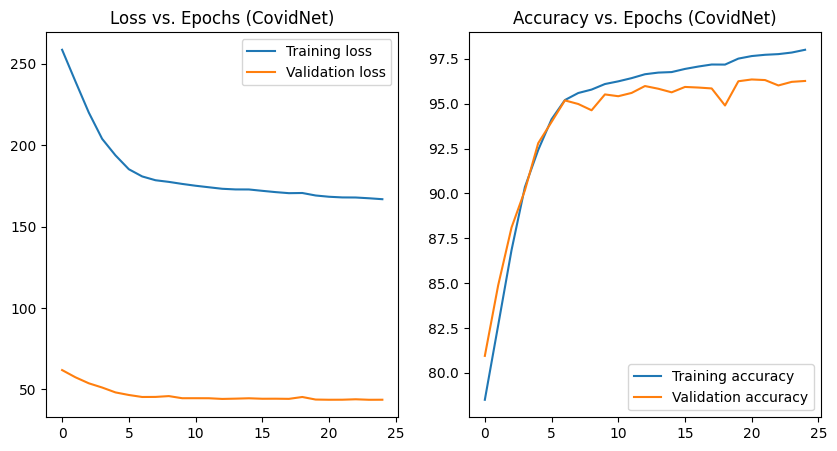

In [17]:
# plot training and validation losses and accuracies
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H%M%S")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss vs. Epochs (CovidNet)")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy vs. Epochs (CovidNet)")
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend()
plt.savefig('./covid_plots/' + f'loss_covid_net_{lr}_{batch_size}.png')
plt.show()

Test data

In [19]:
# test data
test_dataset = COVIDDataset('test.txt', transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# load best model
model.load_state_dict(torch.load('new_covid_net.pt'))

# evaluate model on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%')

Validating: 100%|██████████| 7/7 [00:24<00:00,  3.46s/batch]

  * Validation took: 0:00:24
Test loss: 2.8933, Test accuracy: 89.25%
